# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [2]:
model_name = 'deepseek-coder-v2' # "codegeex4" # "llama3" # "qwen2.5" # 
CONFIG = {
    'model': model_name,   
}

file_db = "~/Downloads/datasets/chinook.db"


clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [3]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

In [4]:
vn = MyVanna(config=CONFIG)

In [5]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [6]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [7]:
vn.run_sql_is_set

True

In [8]:
if clean_and_train:
    vn.remove_collections()

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [9]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [10]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [11]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)


Adding ddl: CREATE TABLE "albums"
(
    [AlbumId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    FOREIGN KEY ([ArtistId]) REFERENCES "artists" ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    [ArtistId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Name] NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    [CustomerId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    FOREIGN KEY ([SupportRepId]) REFERENCES "employees" ([EmployeeId]) 
		ON DELETE NO ACTION 

In [12]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,039f9d54-59f7-5f29-8c04-14dbc3e95671-ddl,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
1,0db84e3d-ef41-563c-803e-21c1b985dc19-ddl,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
2,10cba811-ddba-5042-9e90-d764dfcd1629-ddl,None,"CREATE INDEX IFK_InvoiceCustomerId ON ""invoice...",ddl
3,2c711317-b93d-5f60-a728-cb1c6fcbc040-ddl,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
4,37319c81-65f7-50ee-956b-795de244bee5-ddl,None,"CREATE TABLE sqlite_stat1(tbl,idx,stat)",ddl
5,40bd77cd-e1de-5872-8693-624117ff413c-ddl,None,"CREATE INDEX IFK_InvoiceLineInvoiceId ON ""invo...",ddl
6,41130543-7164-562a-90a7-0fd0a409c154-ddl,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
7,458debc8-8082-5450-a17a-66028bd55ace-ddl,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
8,4815f3fd-925b-53ce-9dfa-0e4285d5abd3-ddl,None,"CREATE TABLE ""invoice_items""\r\n(\r\n Invoi...",ddl
9,48d484e9-984c-58ff-b391-75521c69d486-ddl,None,"CREATE INDEX IFK_PlaylistTrackTrackId ON ""play...",ddl


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfCustomers'].iloc[0],
        title={"text": "Number of Customers"}
    ))
else:
    fig = go.Figure(go.Bar(
        x=['NumberOfCustomers'],
        y=[df['NumberOfCustomers'].iloc[0]]
    ))

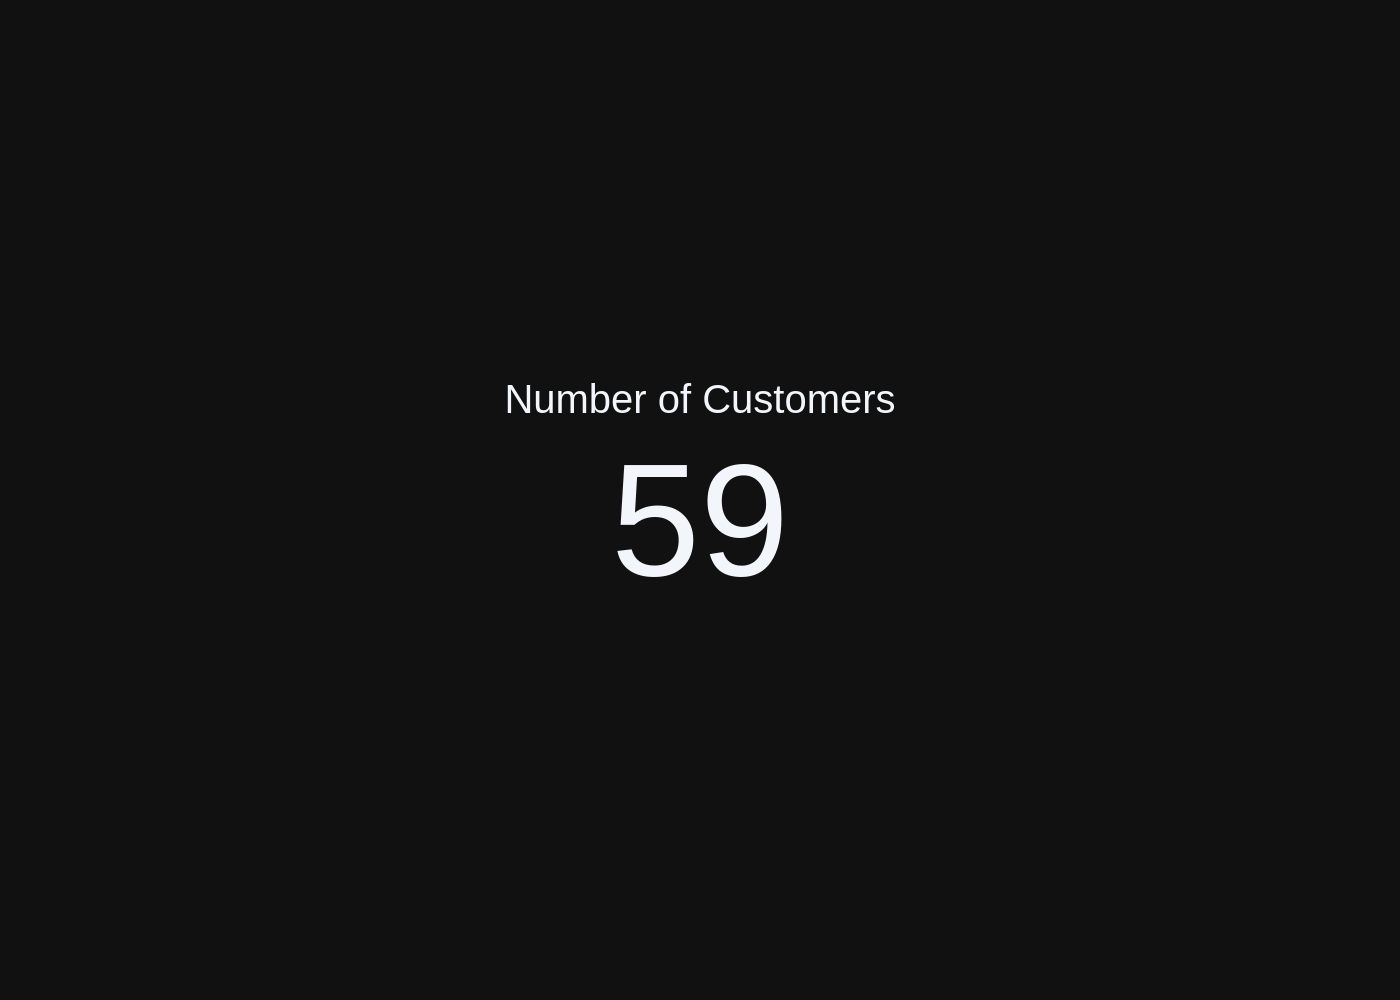

elapsed_time = 11.892843246459961


In [13]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

```sql

SELECT name FROM sqlite_master WHERE type = 'table';

```

```sql

SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [14]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=1,
        title={"text": "Number of Tables"},
        number={'prefix': ''}
    ))
else:
    fig = px.bar(df, y='name', orientation='h')

fig.update_layout(title_text="List of Tables in the SQLite Database")

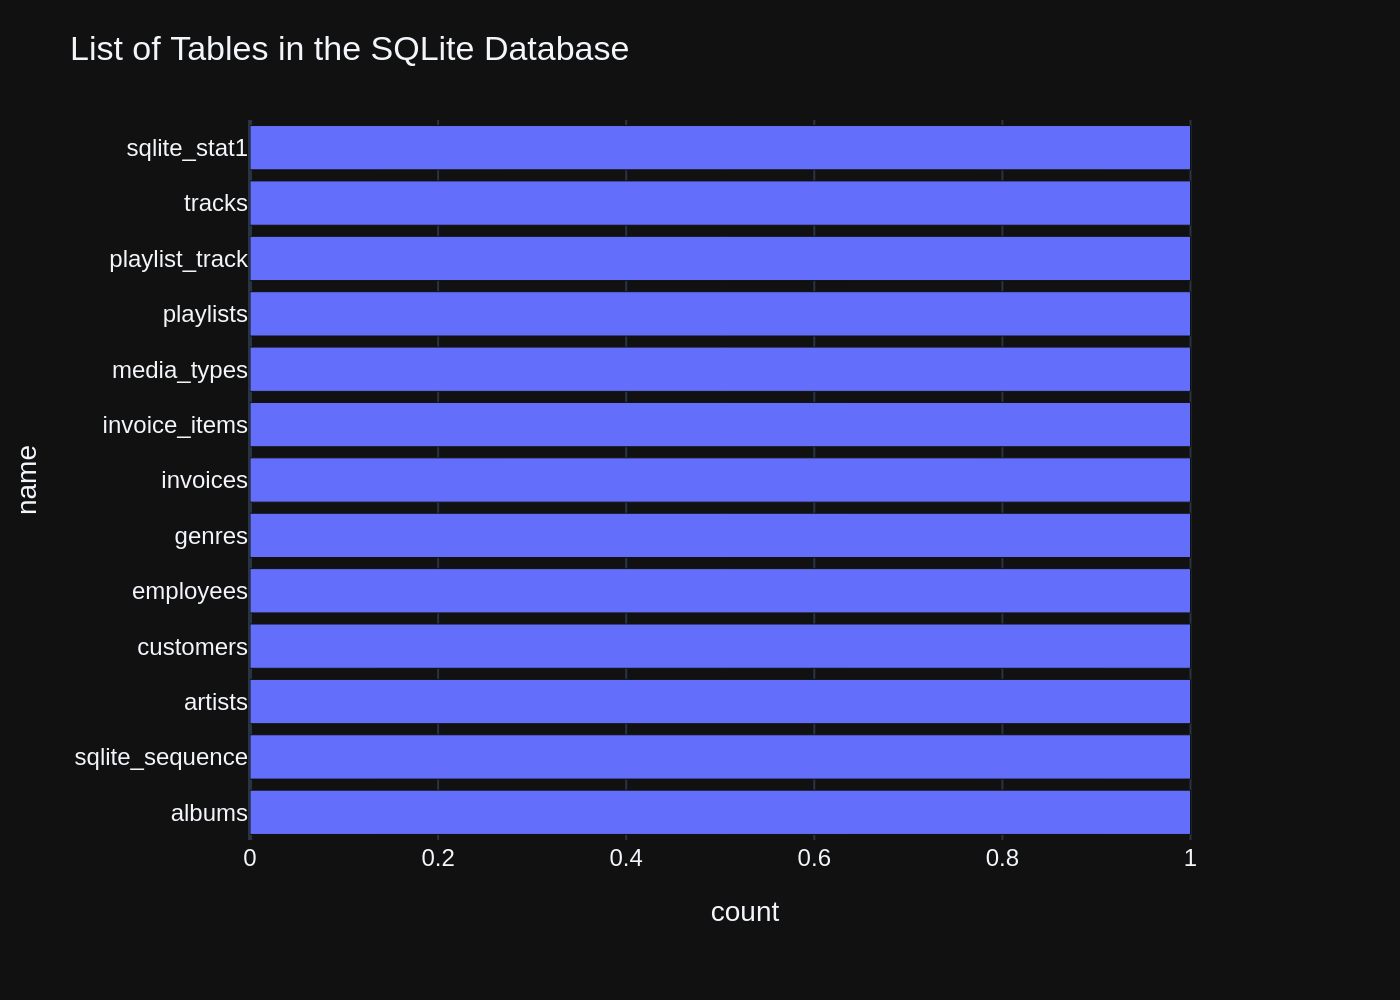





# QUESTION  - 3:  which table stores customer's orders



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table' AND tbl_name LIKE '%invoice%' OR tbl_name LIKE '%order%';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table' AND tbl_name LIKE '%invoice%' OR tbl_name LIKE '%order%';


[( <DataFrame> )]
queried dataframe



,name
0,invoices
1,invoice_items



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(mode="number", value=len(df), title={"text": "Number of Orders/Invoices"}))
else:
    fig = go.Figure(go.Bar(x=df['name'], y=[1]*len(df), text_auto='.2s'))

fig.update_layout(title="Tables Storing Customer's Orders or Invoices")

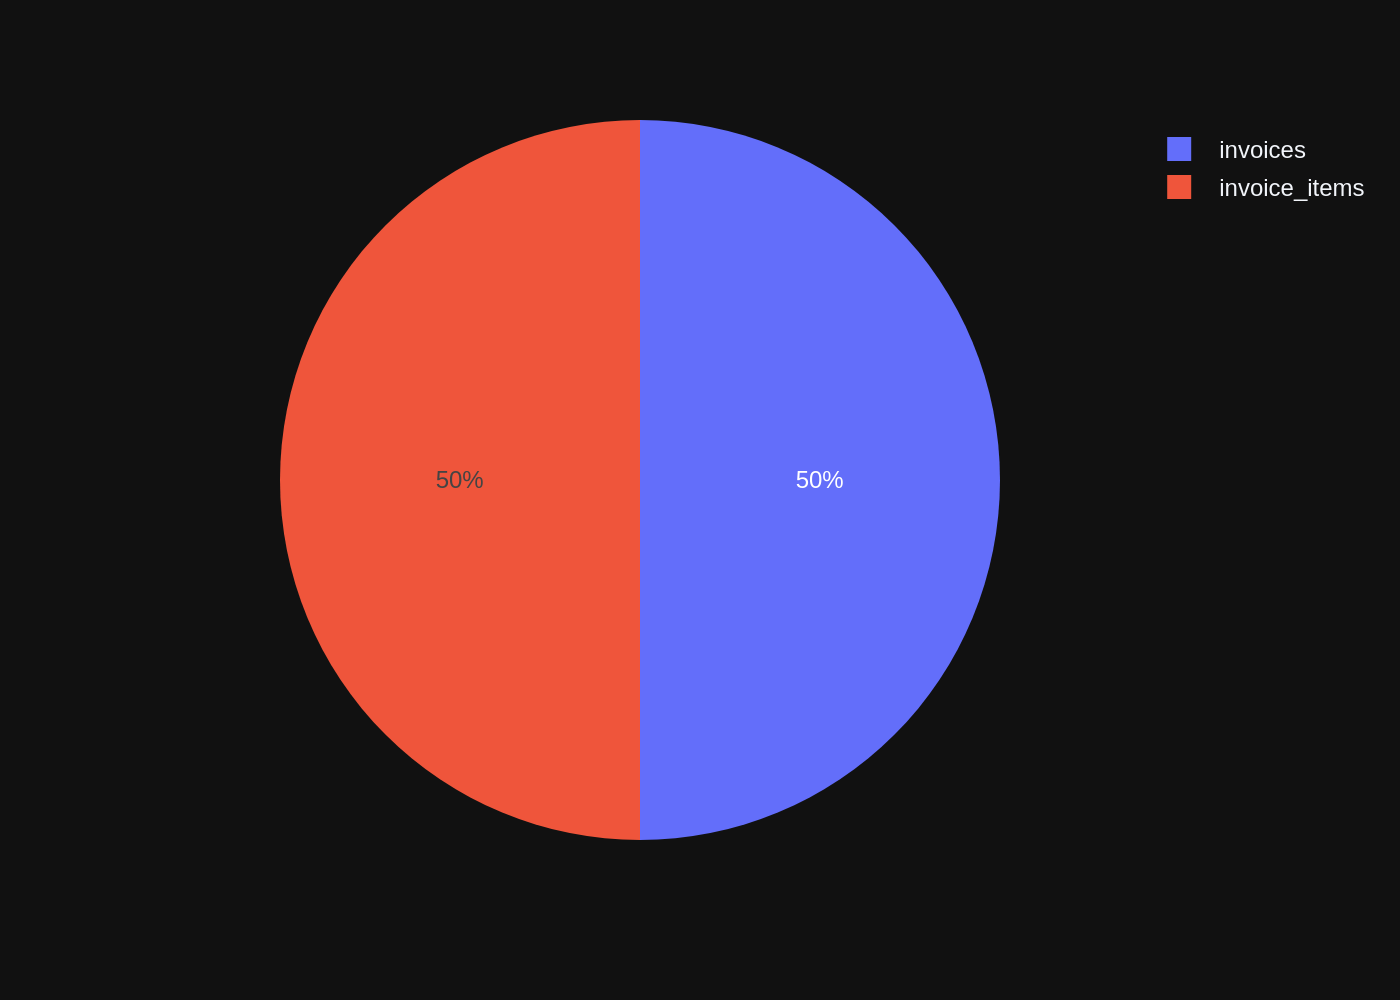





# QUESTION  - 4:  How many customers are there



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if df['NumberOfCustomers'].nunique() == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfCustomers'].iloc[0],
        title={"text": "Number of Customers"}
    ))
else:
    fig = go.Figure(go.Bar(
        x=['NumberOfCustomers'],
        y=[df['NumberOfCustomers'].iloc[0]],
        marker_color='lightblue'
    ))

fig.update_layout(title_text="Number of Customers")

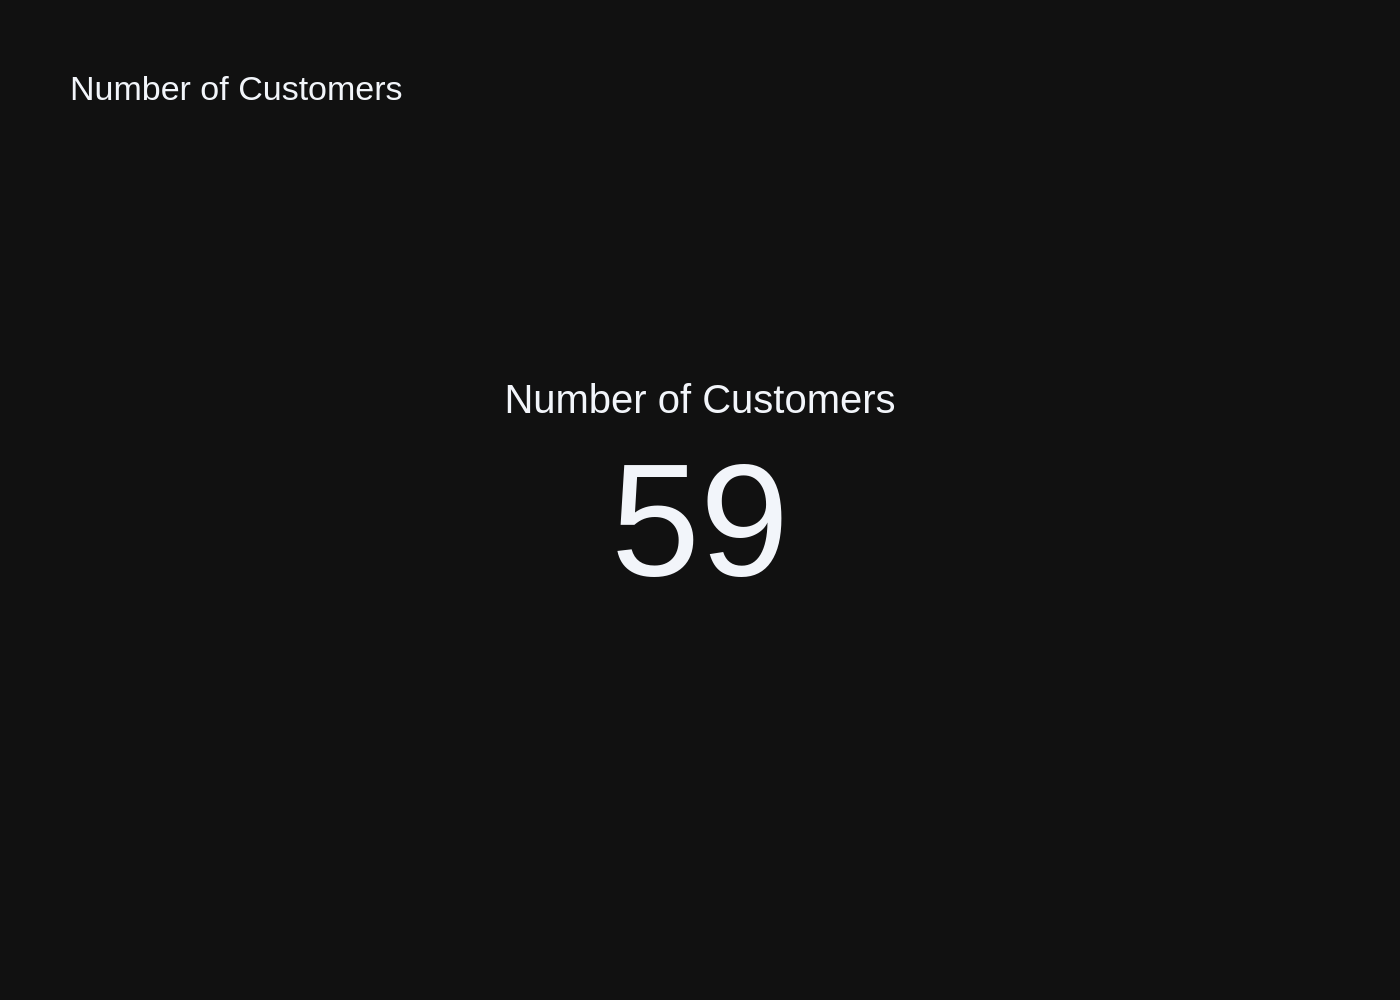





# QUESTION  - 5:  what are the top 5 countries that customers come from?



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS CustomerCount FROM customers GROUP BY BillingCountry ORDER BY CustomerCount DESC LIMIT 5


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT BillingCountry, COUNT(*) AS CustomerCount 
FROM customers 
GROUP BY BillingCountry 
ORDER BY CustomerCount DESC 
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS CustomerCount 
FROM customers 
GROUP BY BillingCountry 
ORDER BY CustomerCount DESC 
LIMIT 5;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT BillingCountry, COUNT(*) AS CustomerCount 
FROM invoices 
GROUP BY BillingCountry 
ORDER BY CustomerCount DESC 
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS CustomerCount 
FROM invoices 
GROUP BY BillingCountry 
ORDER BY CustomerCount DESC 
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,BillingCountry,CustomerCount
0,USA,91
1,Canada,56
2,France,35
3,Brazil,35
4,Germany,28



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure()

if df['CustomerCount'].nunique() == 1:
    fig.add_trace(go.Indicator(
        mode="number",
        value=df['CustomerCount'].iloc[0],
        title={"text": "Top Country Customer Count"},
        domain={'row': 1, 'column': 1}
    ))
else:
    fig.add_trace(go.Bar(
        x=df['BillingCountry'],
        y=df['CustomerCount'],
        marker_color='lightblue'
    ))

fig.update_layout(title="Top 5 Countries by Customer Count", height=600, width=800)

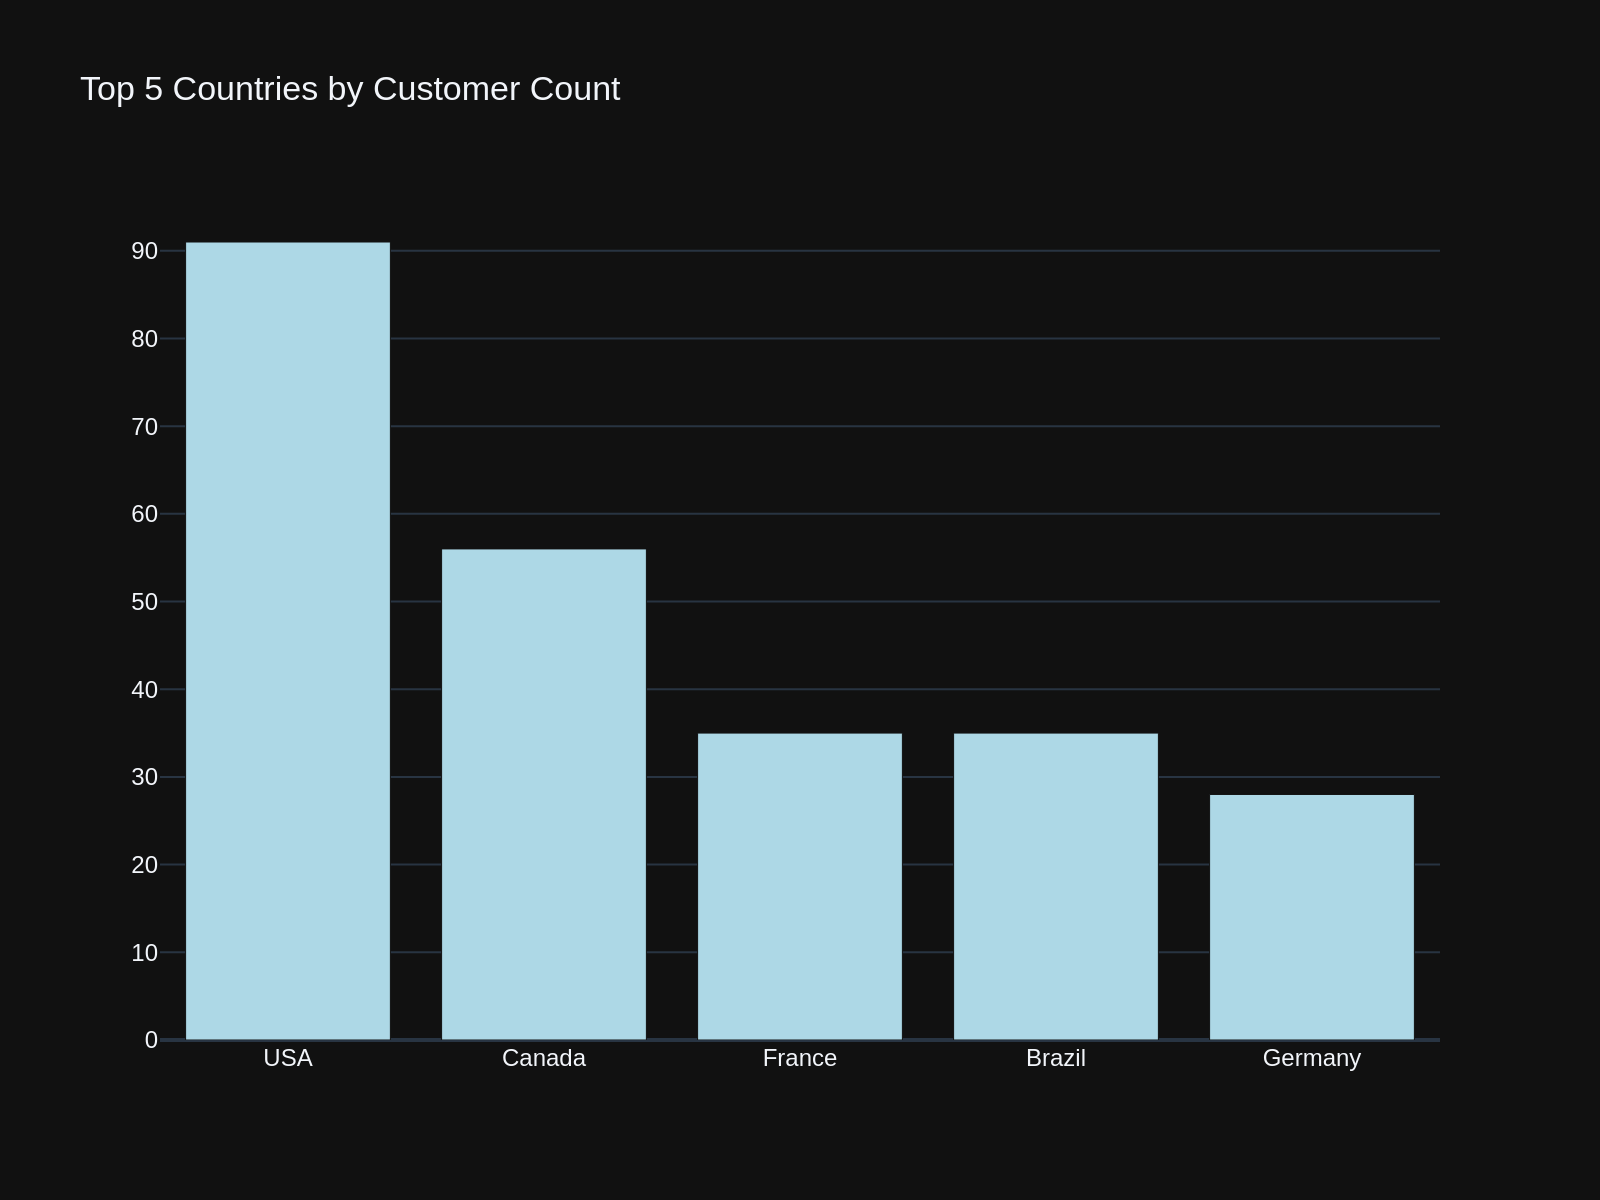





# QUESTION  - 6:  List all albums and their corresponding artist names  



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT a.Title AS AlbumTitle, ar.Name AS ArtistName
FROM albums a
JOIN artists ar ON a.ArtistId = ar.ArtistId
ORDER BY a.Title ASC;


[( <SQL> )]
generated SQL statement



SELECT a.Title AS AlbumTitle, ar.Name AS ArtistName
FROM albums a
JOIN artists ar ON a.ArtistId = ar.ArtistId
ORDER BY a.Title ASC;


[( <DataFrame> )]
queried dataframe



,AlbumTitle,ArtistName
0,...And Justice For All,Metallica
1,20th Century Masters - The Millennium Collecti...,Scorpions
2,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra
3,A Matter of Life and Death,Iron Maiden
4,A Real Dead One,Iron Maiden
5,A Real Live One,Iron Maiden
6,A Soprano Inspired,"Britten Sinfonia, Ivor Bolton & Lesley Garrett"
7,A TempestadeTempestade Ou O Livro Dos Dias,Legião Urbana
8,A-Sides,Soundgarden
9,Ace Of Spades,Motörhead



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['AlbumTitle'].iloc[0],
        title={"text": "Album Title"},
        number={'prefix': ''}
    ))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=['AlbumTitle', 'ArtistName']), cells=dict(values=[[str(i) for i in df['AlbumTitle']], [str(j) for j in df['ArtistName']]]))])

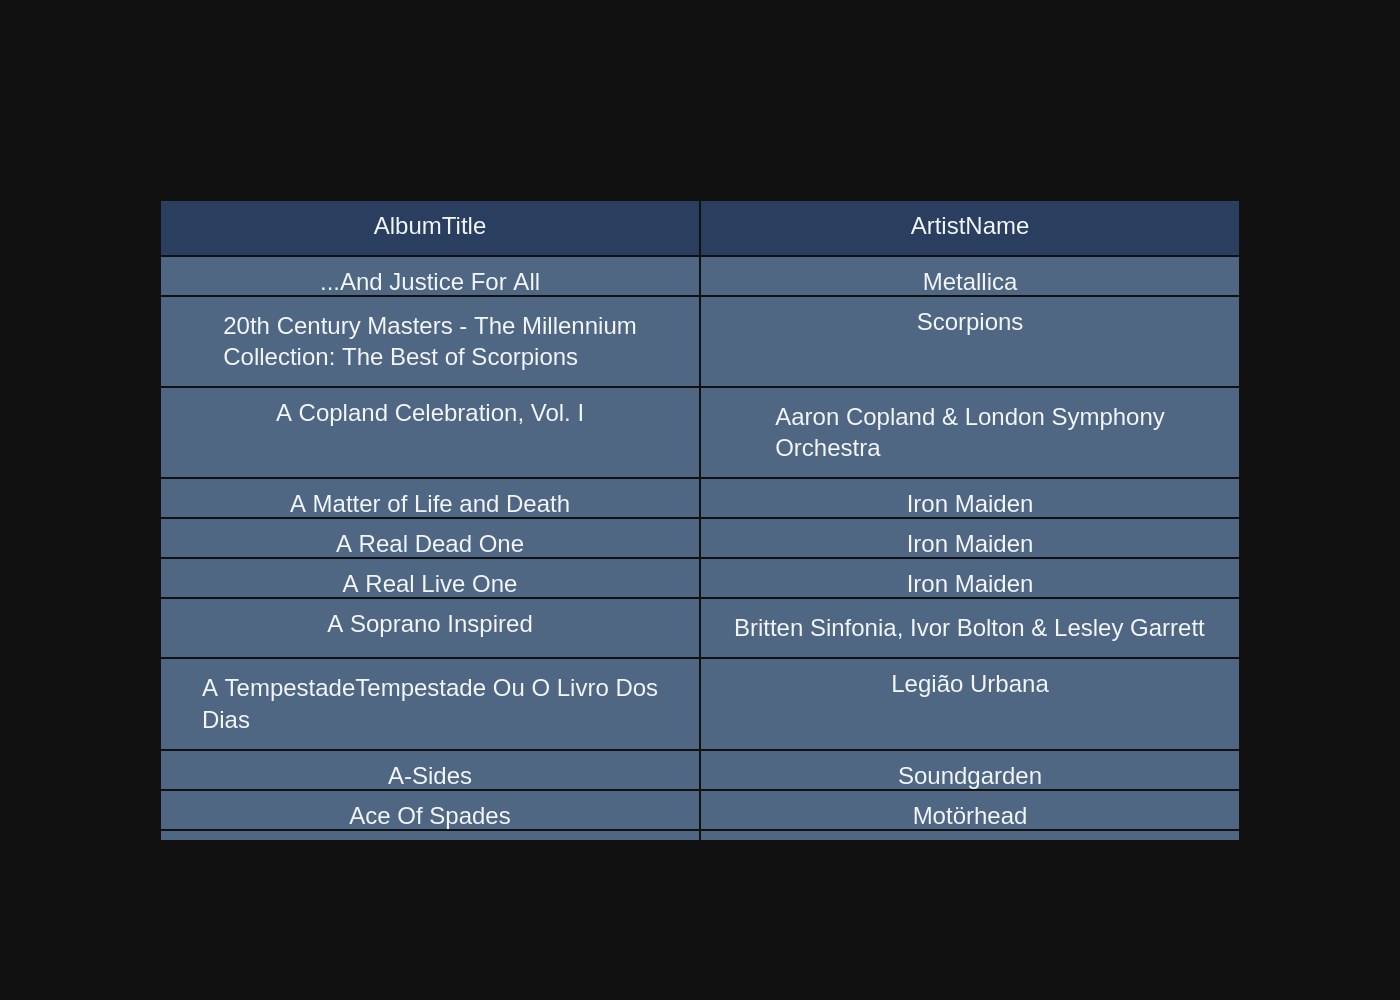





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT DISTINCT LOWER(Name) AS TrackName 
FROM tracks 
WHERE LOWER(Name) LIKE '%what%';


[( <SQL> )]
generated SQL statement



SELECT DISTINCT LOWER(Name) AS TrackName 
FROM tracks 
WHERE LOWER(Name) LIKE '%what%';


[( <DataFrame> )]
queried dataframe



,TrackName
0,what it takes
1,what you are
2,do what cha wanna
3,what is and should never be
4,so what
5,what a day
6,what if i do?
7,what now my love
8,whatsername
9,"whatever it is, i just can't stop"



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=len(df),
        title={"text": "Number of Tracks"},
        number={'prefix': ""}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['TrackName'], y=df['count'])])

fig.update_layout(title='Tracks with Name Containing "What"')

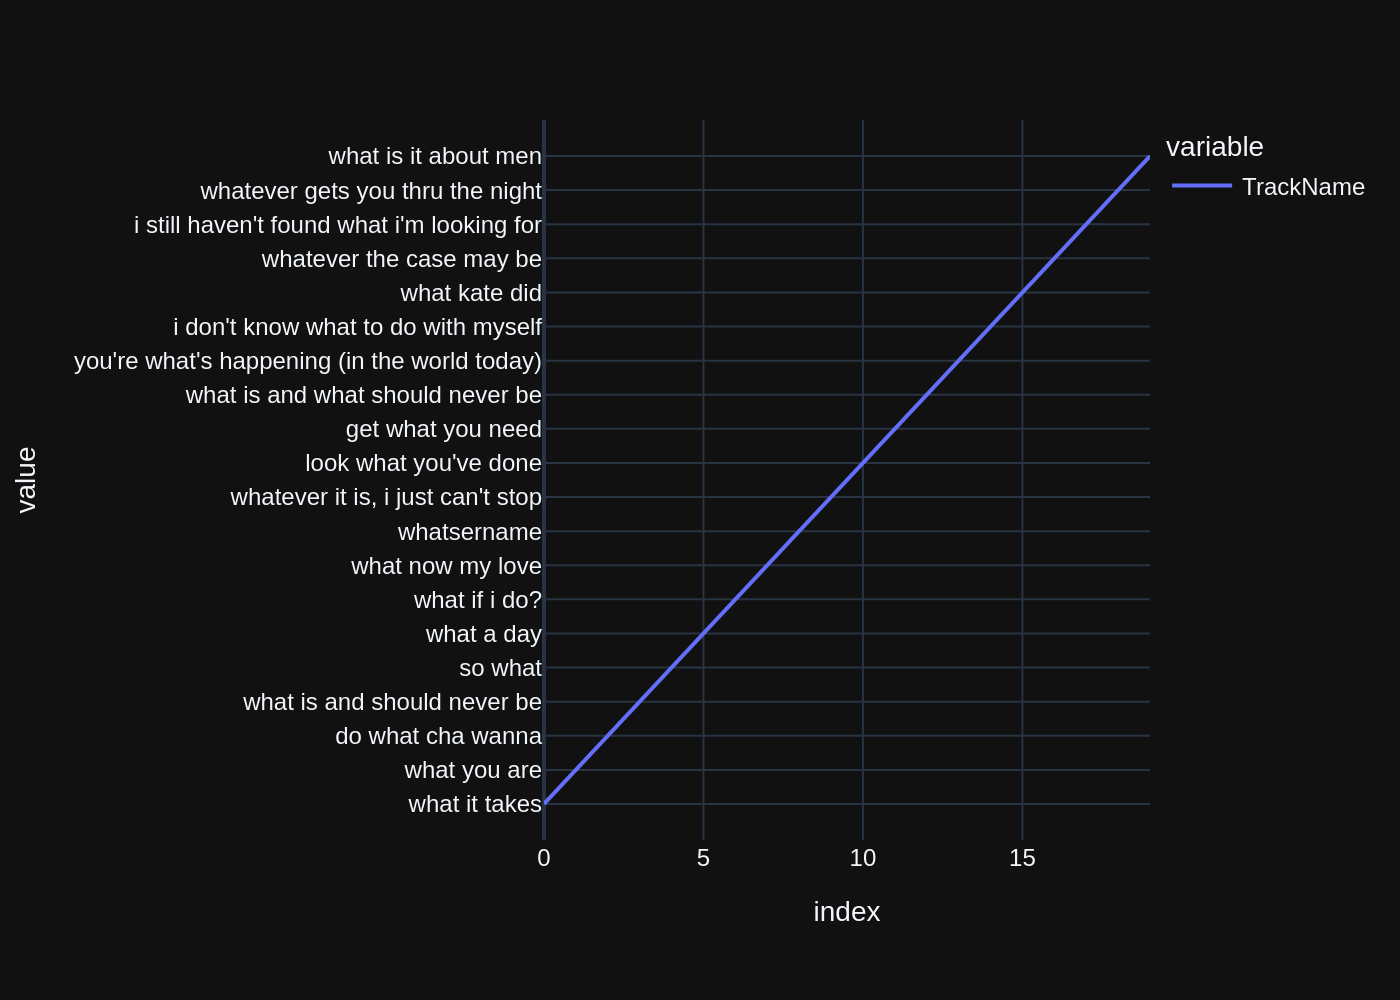





# QUESTION  - 8:  Get the total number of invoices for each customer



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
with the `invoices` table. Here is how you can do it in SQLite:

```sql
SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY c.CustomerId;


[( <SQL> )]
generated SQL statement



with the `invoices` table. Here is how you can do it in SQLite:

```sql
SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY c.CustomerId;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY c.CustomerId LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY c.CustomerId LIMIT 20;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,TotalInvoices
0,1,Luís,Gonçalves,7
1,2,Leonie,Köhler,7
2,3,François,Tremblay,7
3,4,Bjørn,Hansen,7
4,5,František,Wichterlová,7
5,6,Helena,Holý,7
6,7,Astrid,Gruber,7
7,8,Daan,Peeters,7
8,9,Kara,Nielsen,7
9,10,Eduardo,Martins,7



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure()

if df['TotalInvoices'].nunique() == 1:
    fig.add_trace(go.Indicator(
        mode="number",
        value=df['TotalInvoices'].iloc[0],
        title={"text": "Total Invoices"}
    ))
else:
    fig.add_bar(x=df['FirstName'], y=df['TotalInvoices'], name='Total Invoices')

fig.update_layout(title="Total Invoices by Customer", xaxis_tickangle=-45)

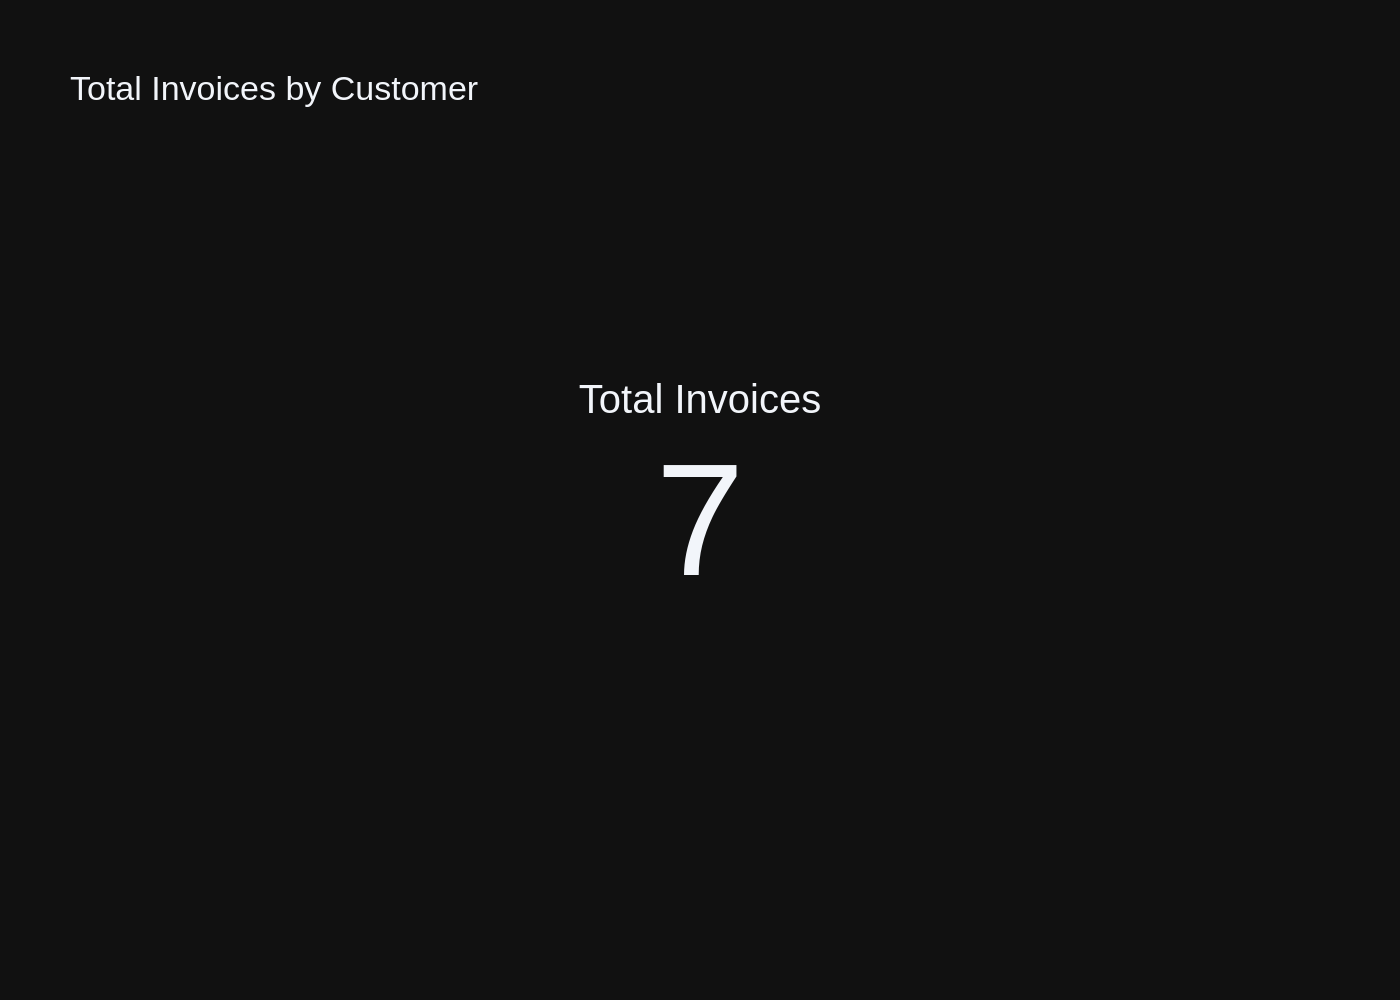





# QUESTION  - 9:  Find the total number of invoices per country



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT BillingCountry, COUNT(*) AS TotalInvoicesPerCountry 
FROM invoices 
GROUP BY BillingCountry 
ORDER BY TotalInvoicesPerCountry DESC;


[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS TotalInvoicesPerCountry 
FROM invoices 
GROUP BY BillingCountry 
ORDER BY TotalInvoicesPerCountry DESC;


[( <DataFrame> )]
queried dataframe



,BillingCountry,TotalInvoicesPerCountry
0,USA,91
1,Canada,56
2,France,35
3,Brazil,35
4,Germany,28
5,United Kingdom,21
6,Portugal,14
7,Czech Republic,14
8,India,13
9,Sweden,7



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['TotalInvoicesPerCountry'].iloc[0],
        title={"text": "Total Invoices"},
        number={'prefix': ''}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['BillingCountry'], y=df['TotalInvoicesPerCountry'])])

fig.update_layout(title='Total Number of Invoices per Country', xaxis_title='Country', yaxis_title='Total Invoices')

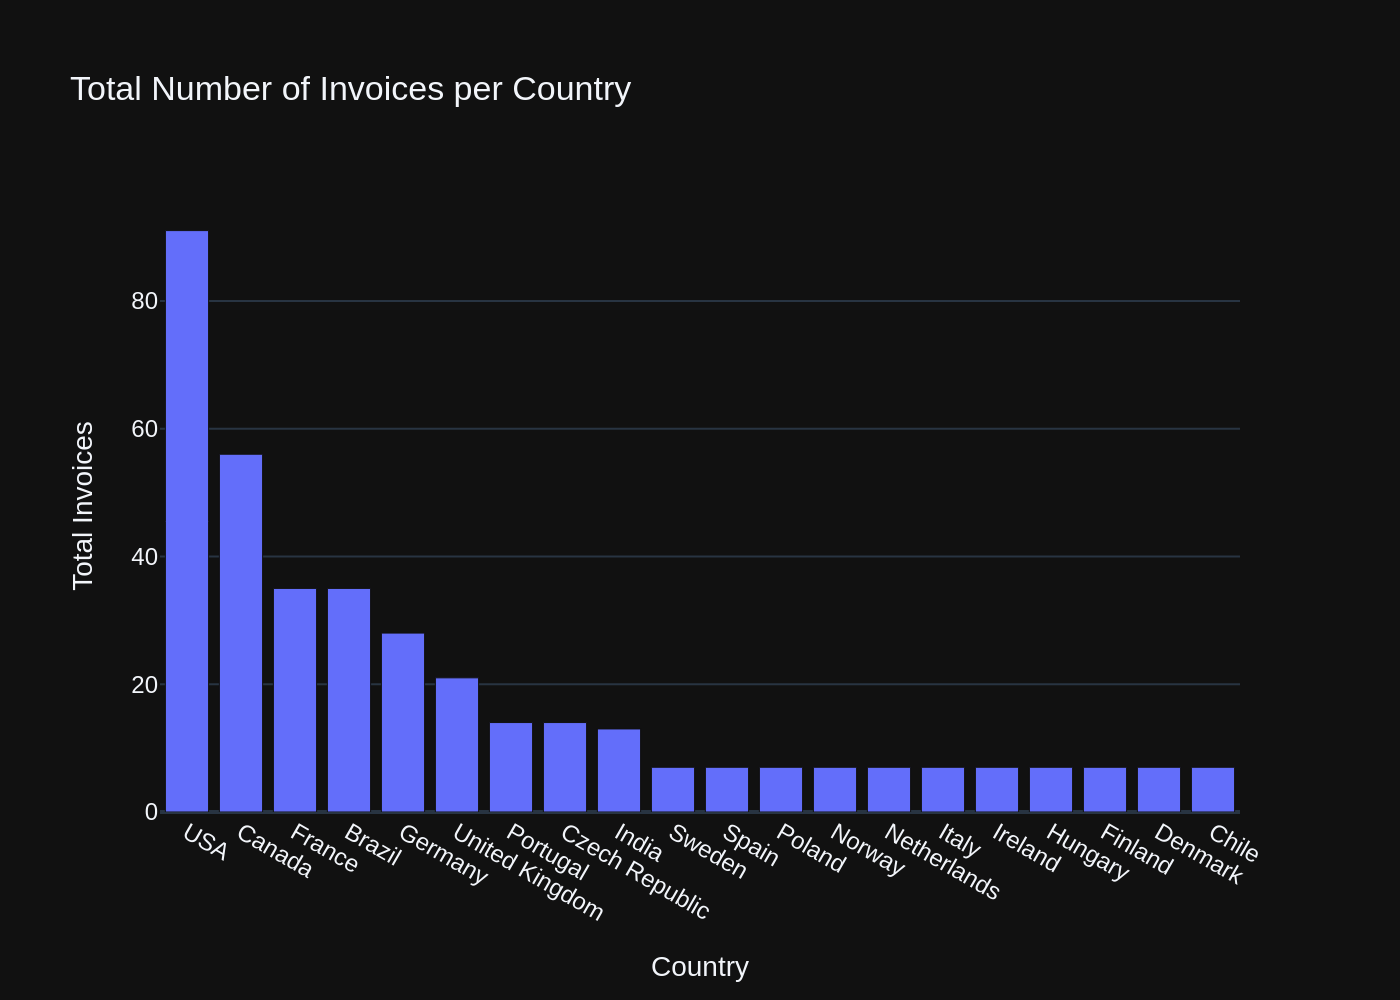





# QUESTION  - 10:  List all invoices with a total exceeding $10



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT InvoiceId, CustomerId, InvoiceDate, Total 
FROM invoices 
WHERE Total > 10 
ORDER BY InvoiceDate DESC LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT InvoiceId, CustomerId, InvoiceDate, Total 
FROM invoices 
WHERE Total > 10 
ORDER BY InvoiceDate DESC LIMIT 20;


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,Total
0,411,44,2013-12-14 00:00:00,13.86
1,404,6,2013-11-13 00:00:00,25.86
2,397,27,2013-10-13 00:00:00,13.86
3,390,48,2013-09-12 00:00:00,13.86
4,383,10,2013-08-12 00:00:00,13.86
5,376,31,2013-07-12 00:00:00,13.86
6,369,52,2013-06-11 00:00:00,13.86
7,362,14,2013-05-11 00:00:00,13.86
8,355,35,2013-04-10 00:00:00,13.86
9,348,56,2013-03-10 00:00:00,13.86



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure()

if len(df) == 1:
    fig.add_trace(go.Indicator(
        mode="number",
        value=df['Total'].values[0],
        title={"text": "Total"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig.add_trace(go.Scatter(
        x=df['InvoiceDate'],
        y=df['Total'],
        mode='lines+markers',
        name='Invoice Total'
    ))

fig.update_layout(title='Invoices with Total Exceeding $10')

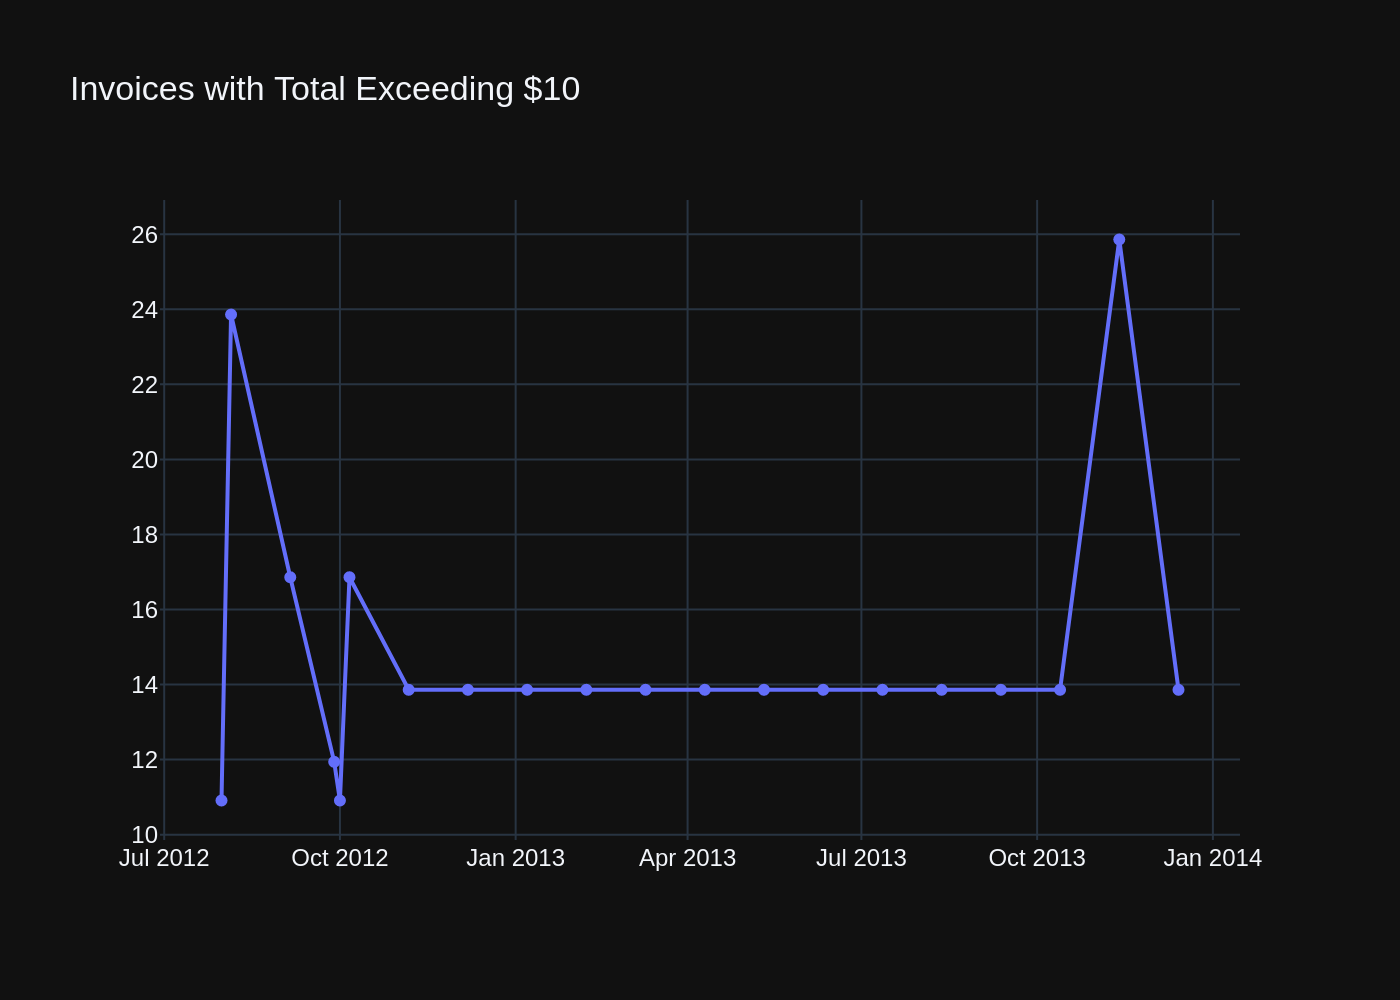





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <SQL> )]
generated SQL statement



SELECT InvoiceDate, Total 
FROM invoices 
WHERE InvoiceDate >= '2010-01-01' 
ORDER BY InvoiceDate ASC LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceDate,Total
0,2010-01-08 00:00:00,1.98
1,2010-01-08 00:00:00,1.98
2,2010-01-09 00:00:00,3.96
3,2010-01-10 00:00:00,6.94
4,2010-01-13 00:00:00,17.91
5,2010-01-18 00:00:00,18.86
6,2010-01-26 00:00:00,0.99
7,2010-02-08 00:00:00,1.98
8,2010-02-08 00:00:00,1.98
9,2010-02-09 00:00:00,3.96



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assuming df is already defined and contains the data
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['Total'].values[0],
        number={'prefix': '$', 'suffix': ''},
        title={"text": "Total Amount Invoiced"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=go.Scatter(
        x=df['InvoiceDate'],
        y=df['Total'],
        mode='lines+markers',
        line=dict(color='blue'),
        marker=dict(size=10, color='rgba(152, 173, 234, .9)'),
    ))

fig.update_layout(title="Total Amount Invoiced Over Time",
                  xaxis_title="Invoice Date",
                  yaxis_title="Total Amount ($)")

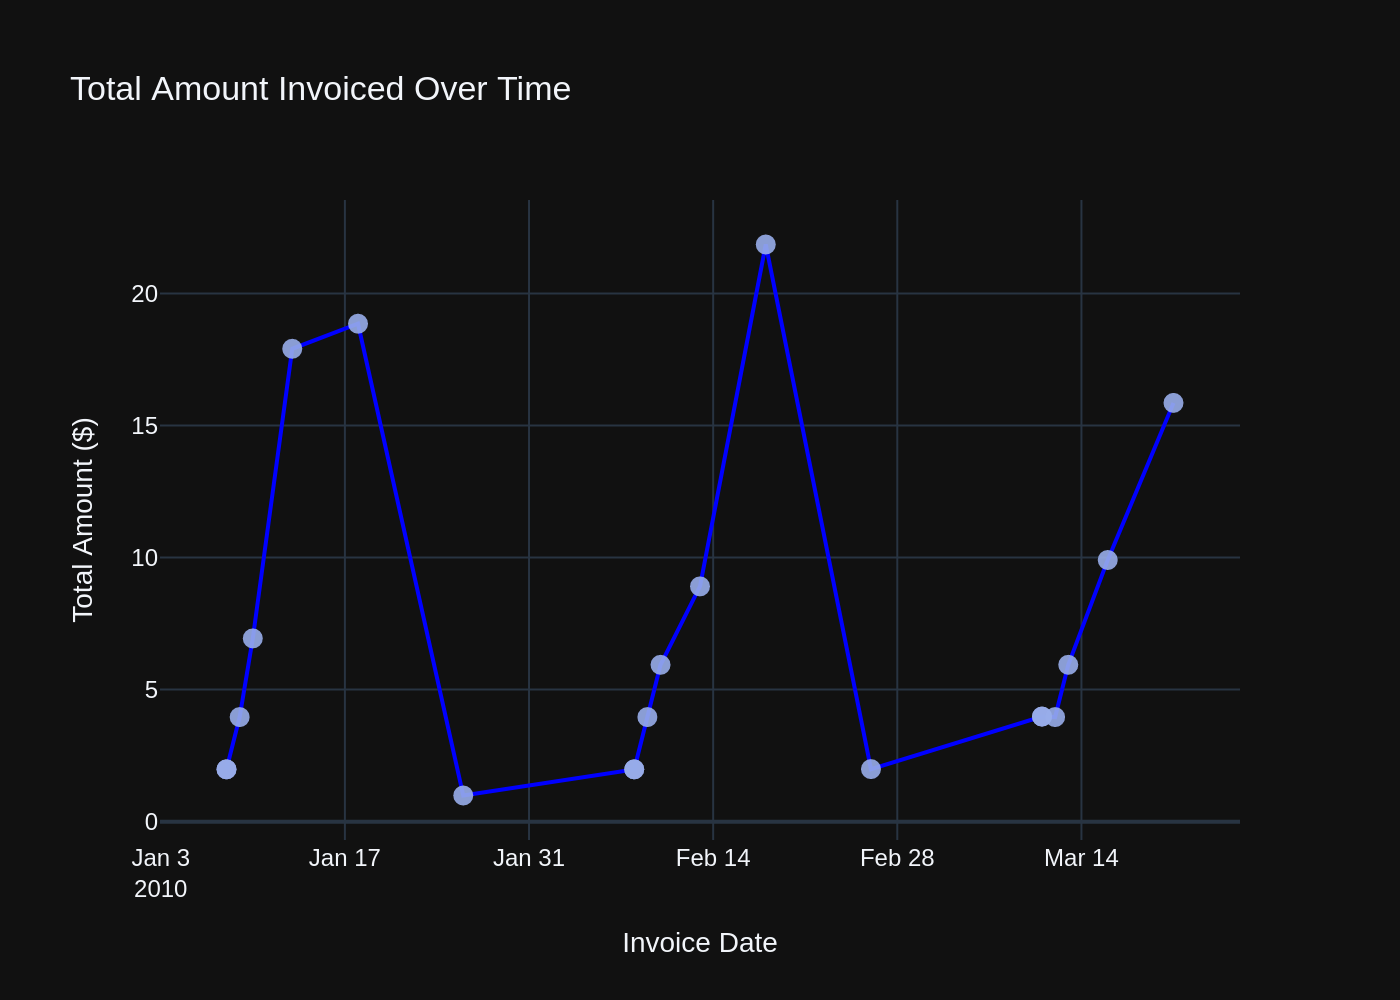





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, m.FirstName || ' ' || m.LastName AS ManagerName
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId;


[( <SQL> )]
generated SQL statement



SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, m.FirstName || ' ' || m.LastName AS ManagerName
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId;


[( <DataFrame> )]
queried dataframe



,EmployeeName,ManagerName
0,Andrew Adams,None
1,Nancy Edwards,Andrew Adams
2,Jane Peacock,Nancy Edwards
3,Margaret Park,Nancy Edwards
4,Steve Johnson,Nancy Edwards
5,Michael Mitchell,Andrew Adams
6,Robert King,Michael Mitchell
7,Laura Callahan,Michael Mitchell



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['EmployeeName'].iloc[0],
        title={"text": "Unique Employee"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Table(
        header=dict(values=['EmployeeName', 'ManagerName'], fill_color='paleturquoise', align='left'),
        cells=dict(values=[df['EmployeeName'], df['ManagerName']], fill_color='lavender', align='left'))
    ])

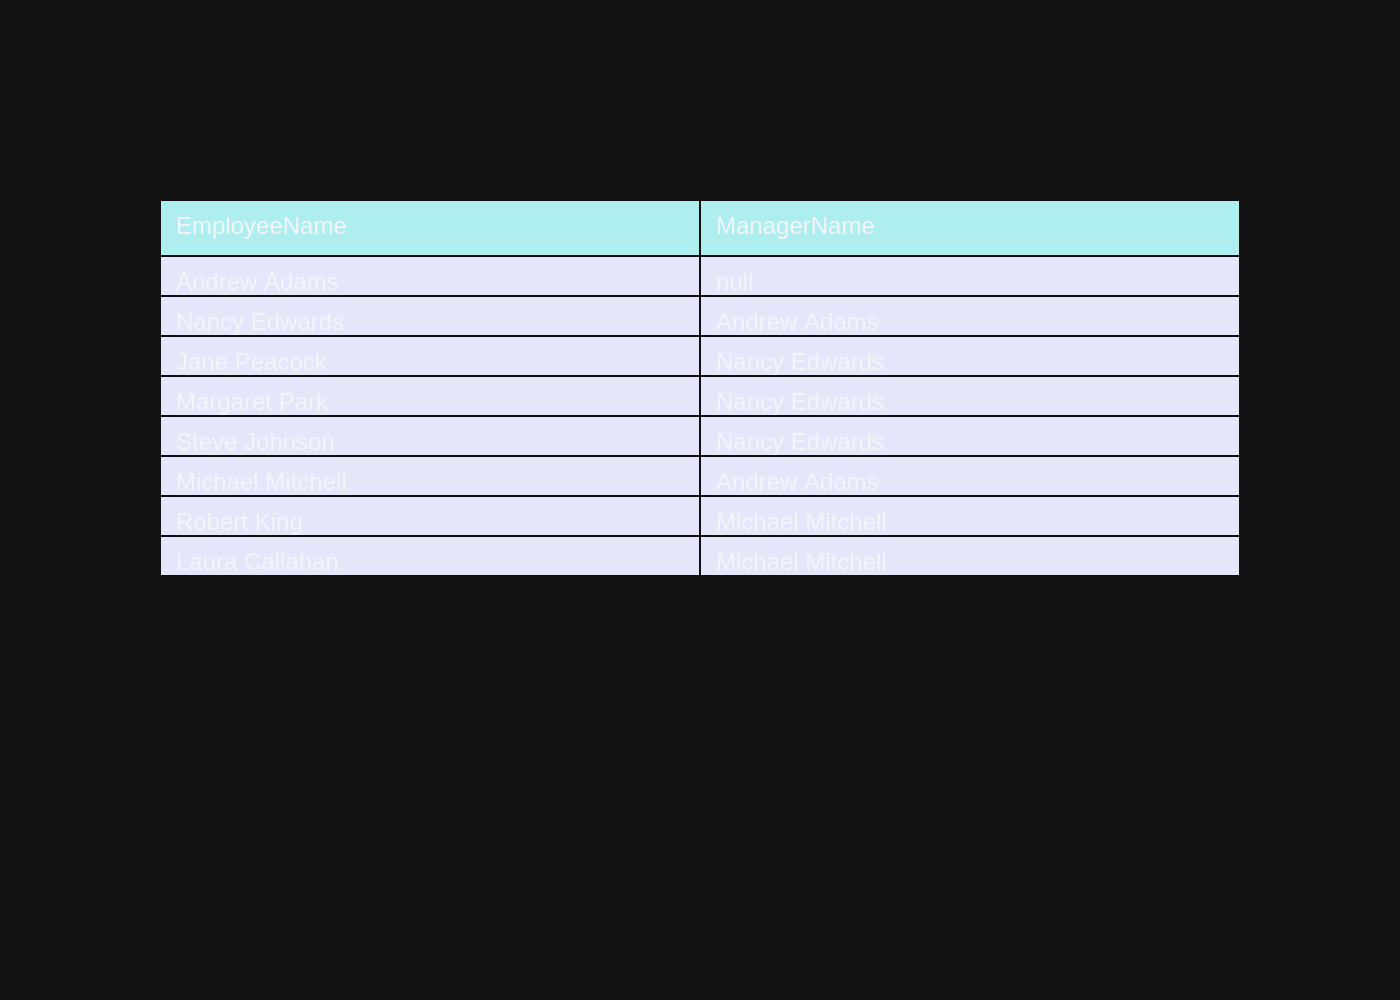





# QUESTION  - 13:   Get the average invoice total for each customer:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, AVG(i.Total) AS AverageInvoiceTotal
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY c.CustomerId LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,AverageInvoiceTotal
0,1,Luís,Gonçalves,5.660000
1,2,Leonie,Köhler,5.374286
2,3,François,Tremblay,5.660000
3,4,Bjørn,Hansen,5.660000
4,5,František,Wichterlová,5.802857
5,6,Helena,Holý,7.088571
6,7,Astrid,Gruber,6.088571
7,8,Daan,Peeters,5.374286
8,9,Kara,Nielsen,5.374286
9,10,Eduardo,Martins,5.374286



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px

if df['AverageInvoiceTotal'].nunique() == 1:
    fig = px.indicator(title="Average Invoice Total for Each Customer", value=df['AverageInvoiceTotal'].iloc[0], domain={'x': [0, 1], 'y': [0, 1]})
else:
    fig = px.bar(df, x='CustomerId', y='AverageInvoiceTotal', text='AverageInvoiceTotal')
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.update_layout(title="Average Invoice Total for Each Customer", xaxis_title="Customer Id", yaxis_title="Average Invoice Total")

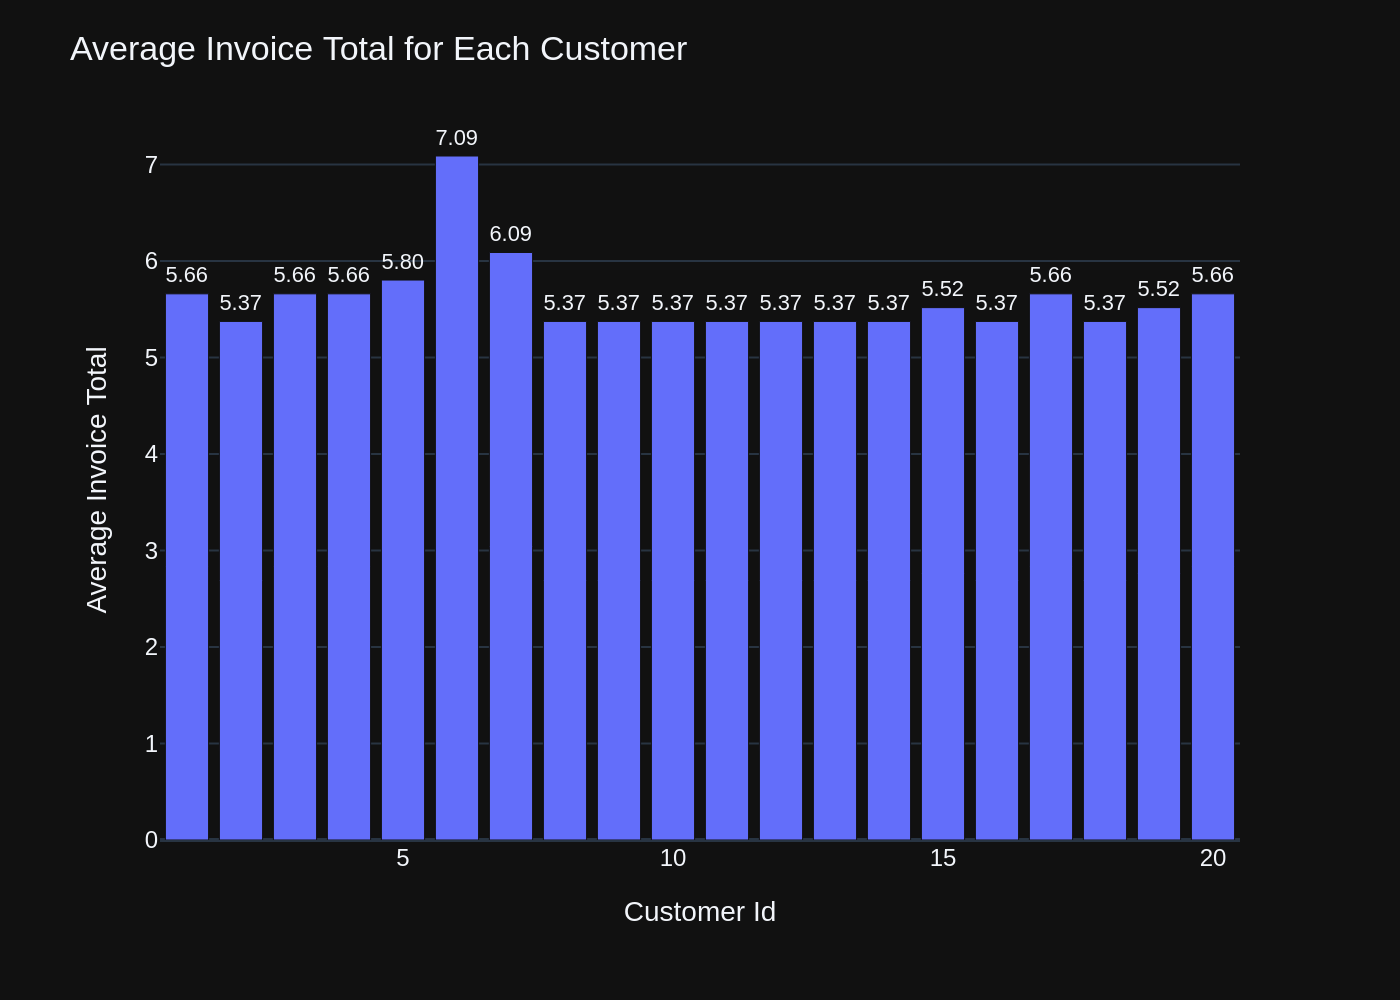





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT TrackId, Name, UnitPrice 
FROM tracks 
ORDER BY UnitPrice DESC 
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT TrackId, Name, UnitPrice 
FROM tracks 
ORDER BY UnitPrice DESC 
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,UnitPrice
0,2819,Battlestar Galactica: The Story So Far,1.99
1,2820,Occupation / Precipice,1.99
2,2821,"Exodus, Pt. 1",1.99
3,2822,"Exodus, Pt. 2",1.99
4,2823,Collaborators,1.99



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['UnitPrice'].values[0],
        number={'prefix': "$"},
        title={"text": "Top 5 Most Expensive Tracks"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['Name'], y=df['UnitPrice'])])
    fig.update_layout(title="Top 5 Most Expensive Tracks", xaxis_title="Track Name", yaxis_title="Unit Price")

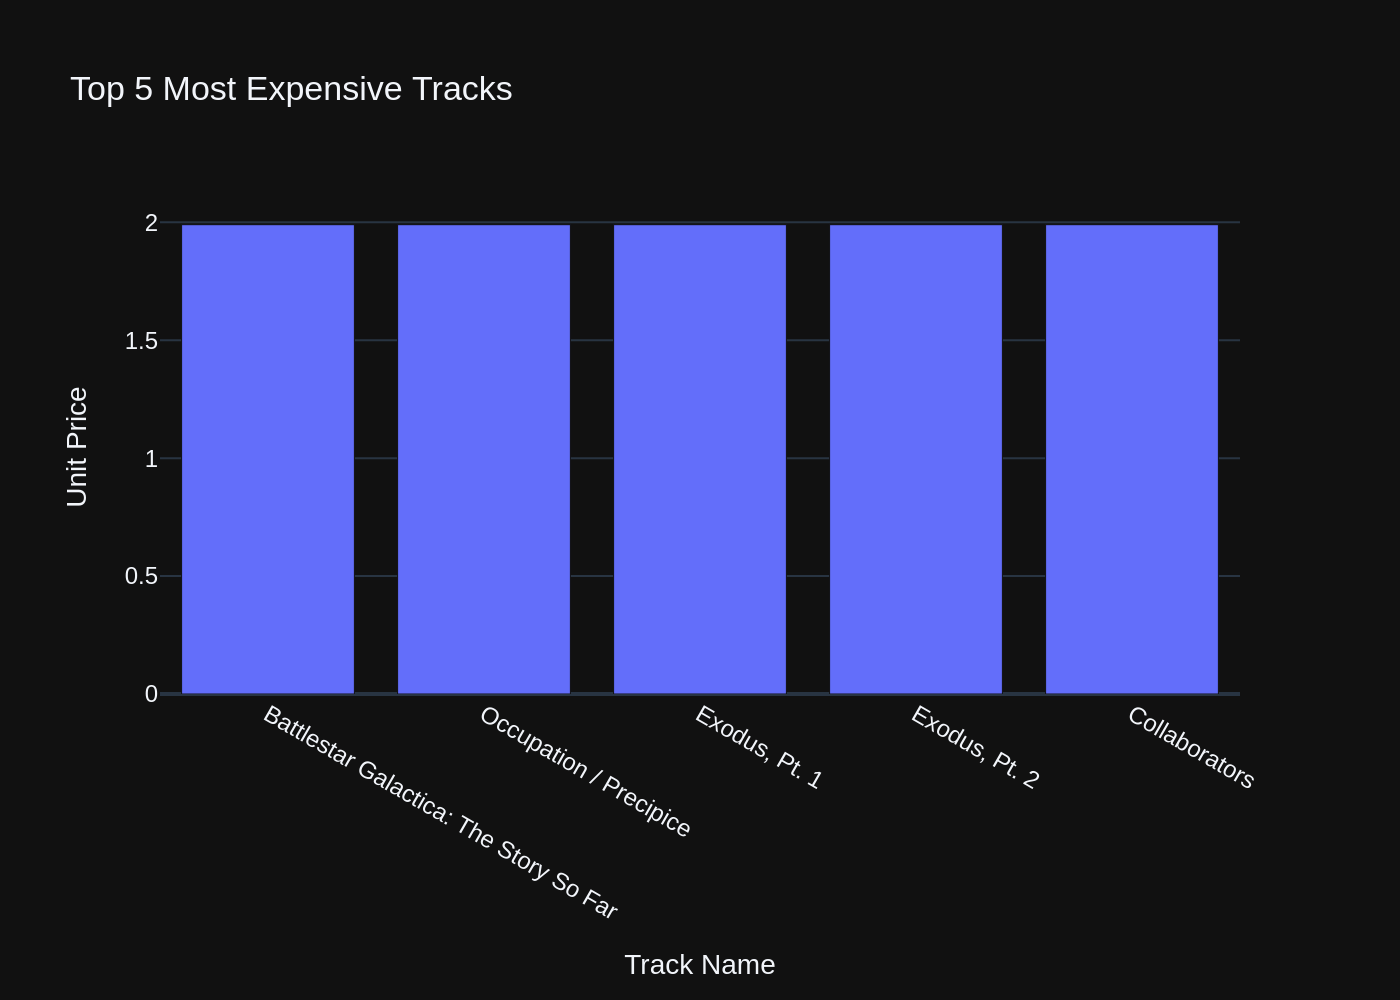





# QUESTION  - 15:  List all genres and the number of tracks in each genre:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT g.Name AS GenreName, COUNT(t.TrackId) AS NumberOfTracks
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
ORDER BY NumberOfTracks DESC LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT g.Name AS GenreName, COUNT(t.TrackId) AS NumberOfTracks
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
ORDER BY NumberOfTracks DESC LIMIT 20;


[( <DataFrame> )]
queried dataframe



,GenreName,NumberOfTracks
0,Rock,1297
1,Latin,579
2,Metal,374
3,Alternative & Punk,332
4,Jazz,130
5,TV Shows,93
6,Blues,81
7,Classical,74
8,Drama,64
9,R&B/Soul,61



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px

if df['NumberOfTracks'].nunique() == 1:
    fig = px.indicator(value=df['NumberOfTracks'].iloc[0], title='Number of Tracks per Genre')
else:
    fig = px.bar(df, x='GenreName', y='NumberOfTracks', text='NumberOfTracks', color='NumberOfTracks', title='Number of Tracks per Genre')

fig.update_layout(xaxis_title="Genre", yaxis_title="Number of Tracks")

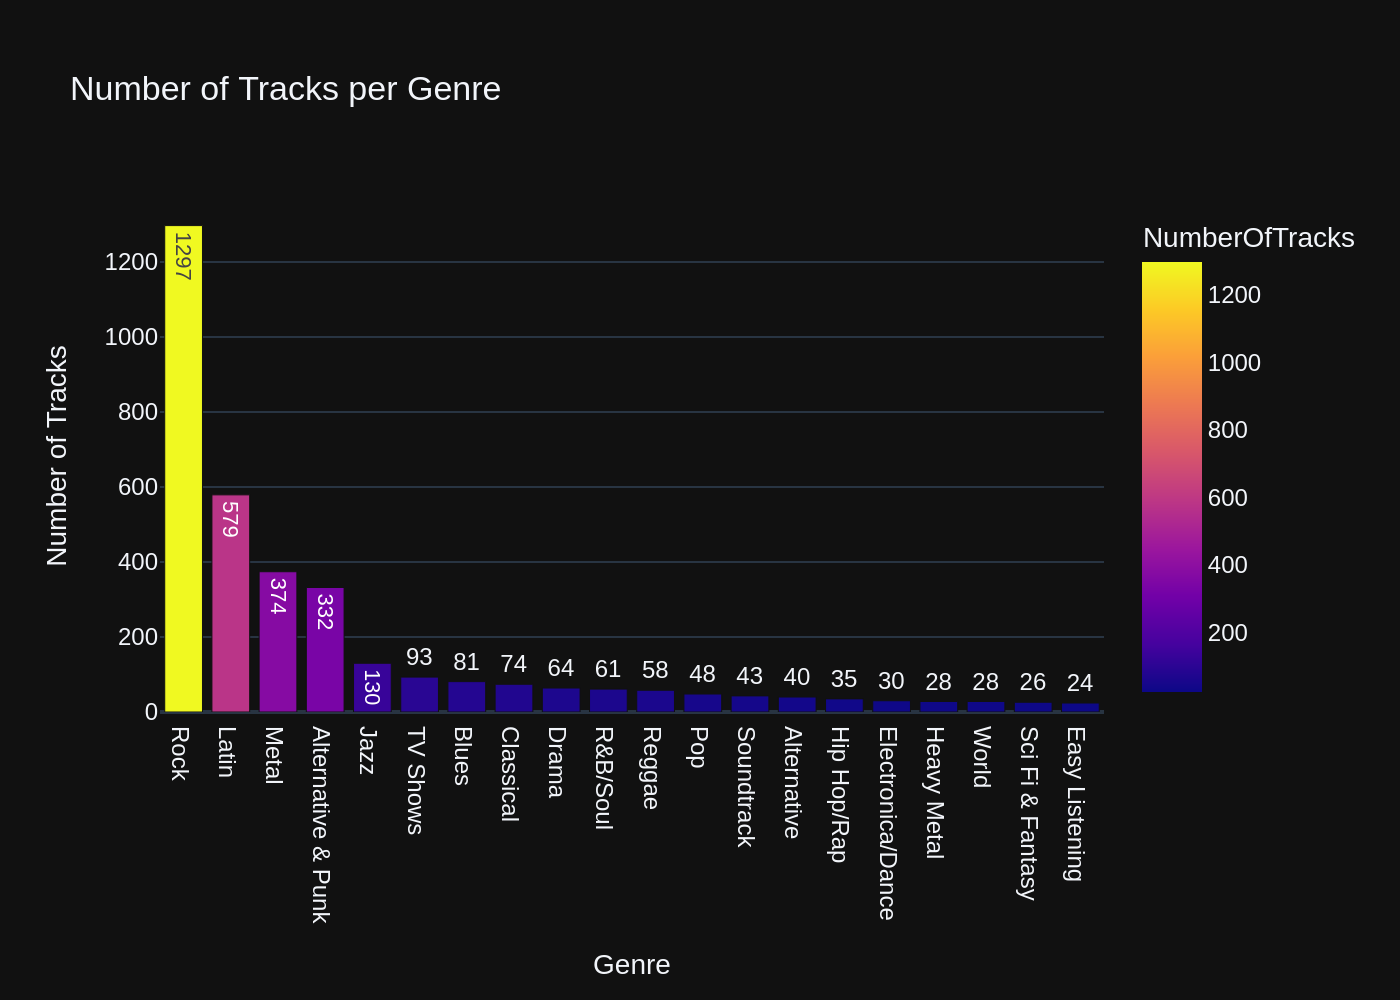





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT g.Name AS GenreName
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT g.Name AS GenreName
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


[( <DataFrame> )]
queried dataframe



,GenreName



[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: Get all genres that do not have any tracks associated with them:
                    results in the following error: [ERROR-DF] Invalid dataframe .
                    Can you try to fix the error and re-generate the SQL statement?
                 with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
with them, you can use a `LEFT JOIN` between the 'genres' table and the 'tracks' table and then filter out those rows where there is no corresponding track. Here is how you can do it in SQLite:

```sql
SELECT g.GenreId, g.Name 
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


[( <SQL>

with them, you can use a `LEFT JOIN` between the 'genres' table and the 'tracks' table and then filter out those rows where there is no corresponding track. Here is how you can do it in SQLite:

```sql
SELECT g.GenreId, g.Name 
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
with them, you can use a LEFT JOIN between the `genres` table and the `tracks` table and then filter out the rows where there are no matching entries in the `tracks` table. Here's how you can write the SQL query:

```sql
SELECT g.GenreId, g.Name 
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


[( <SQL> )]
generated SQL statement



with them, you can use a LEFT JOIN between the `genres` table and the `tracks` table and then filter out the rows where there are no matching entries in the `tracks` table. Here's how you can write the SQL query:

```sql
SELECT g.GenreId, g.Name 
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;





# QUESTION  - 17:  List all customers who have not placed any orders:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all customers who have not placed any orders: with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all customers who have not placed any orders: with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: List all customers who have not placed any orders:
                    results in the following error: [ERROR-SQL] Failed to generate SQL for prompt: List all customers who have

SELECT c.* 
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT c.*
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT c.*
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT a.ArtistId, a.Name AS ArtistName, COUNT(t.TrackId) AS NumberOfTracks
FROM artists a
JOIN albums al ON a.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY a.ArtistId
ORDER BY NumberOfTracks DESC
LIMIT 10;


[( <SQL> )]
generated SQL statement



SELECT a.ArtistId, a.Name AS ArtistName, COUNT(t.TrackId) AS NumberOfTracks
FROM artists a
JOIN albums al ON a.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY a.ArtistId
ORDER BY NumberOfTracks DESC
LIMIT 10;


[( <DataFrame> )]
queried dataframe



,ArtistId,ArtistName,NumberOfTracks
0,90,Iron Maiden,213
1,150,U2,135
2,22,Led Zeppelin,114
3,50,Metallica,112
4,58,Deep Purple,92
5,149,Lost,92
6,118,Pearl Jam,67
7,100,Lenny Kravitz,57
8,21,Various Artists,56
9,156,The Office,53



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px

if len(df) == 1:
    fig = px.indicator(value=df['NumberOfTracks'].iloc[0], title="Top Artist by Number of Tracks")
else:
    fig = px.bar(df, x='ArtistName', y='NumberOfTracks', text_auto='.2s')

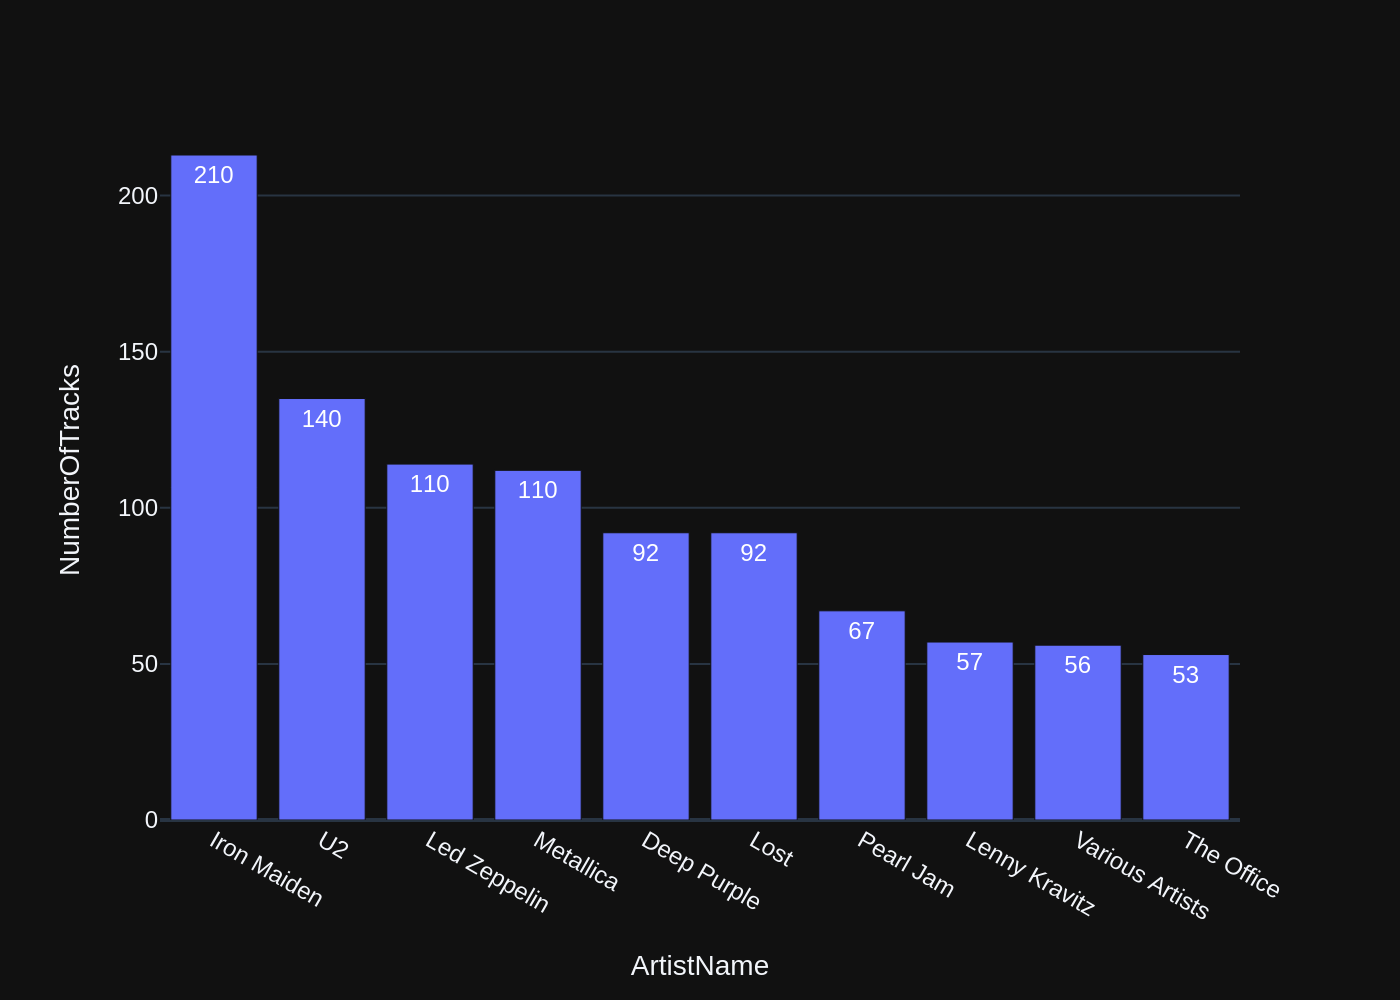





# QUESTION  - 19:  List all customers from Canada and their email addresses:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all customers from Canada and their email addresses: with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all customers from Canada and their email addresses: with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada';


[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada';


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

# Check if the DataFrame has more than one row
if len(df) > 1:
    fig = go.Figure(data=[go.Table(header=dict(values=list(df.columns)), cells=dict(values=[df[col] for col in df.columns]))])
else:
    fig = go.Figure(data=[go.Indicator(value=1, mode="number")])

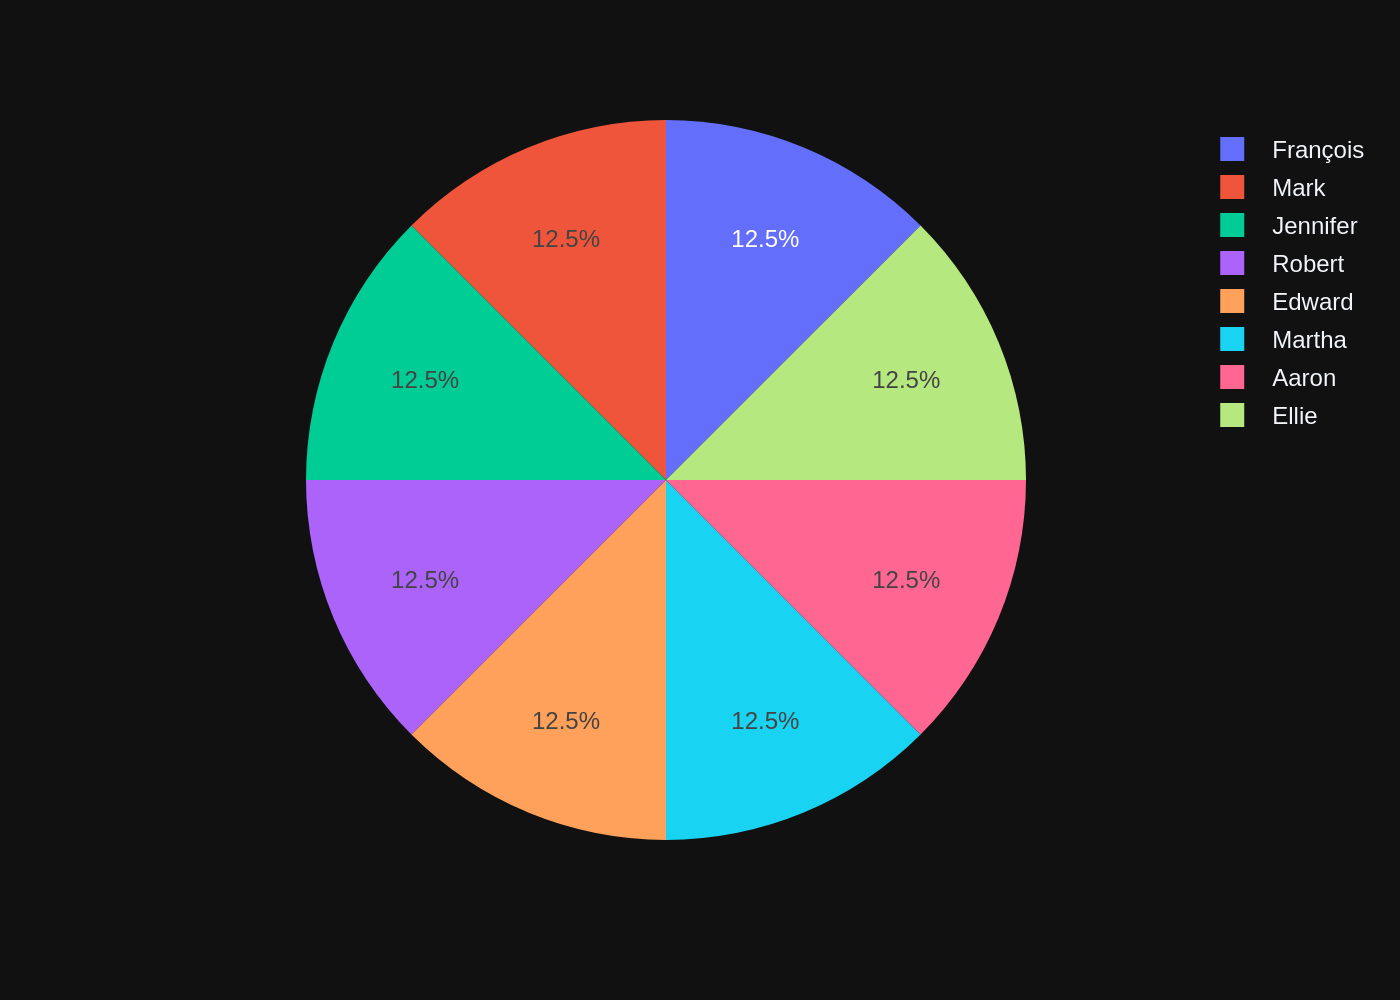





# QUESTION  - 20:  Find the customer with the most invoices 



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find the customer with the most invoices  with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find the customer with the most invoices  with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: Find the customer with the most invoices 
                    results in the following error: [ERROR-SQL] Failed to generate SQL for prompt: Find the customer with the most invoices  with the following ex

with the most invoices, we need to count the number of invoices per customer and then select the one with the highest count. Here's the corrected SQL query for this purpose:

```sql
SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS TotalInvoices
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY TotalInvoices DESC
LIMIT 1;





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find the customer who bought the most albums in total quantity (across all invoices): with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find the customer who bought the most albums in total quantity (across all invoices): with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: Find the customer who bought the most albums in total quantity (across a

SELECT c.CustomerId, c.FirstName, c.LastName, SUM(ii.Quantity) AS TotalAlbumQuantity
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbumQuantity DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,TotalAlbumQuantity
0,1,Luís,Gonçalves,38
1,2,Leonie,Köhler,38
2,3,François,Tremblay,38
3,4,Bjørn,Hansen,38
4,5,František,Wichterlová,38



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

if df['TotalAlbumQuantity'].nunique() == 1:
    fig = px.indicator(title="Top Customers by Total Album Quantity", value=df['TotalAlbumQuantity'].iloc[0], gauge={'axis': {'visible': False}}, height=600)
else:
    fig = px.bar(df, x='CustomerId', y='TotalAlbumQuantity', text='TotalAlbumQuantity', title="Top Customers by Total Album Quantity")

fig.update_layout(xaxis_title="Customer Id", yaxis_title="Total Album Quantity")

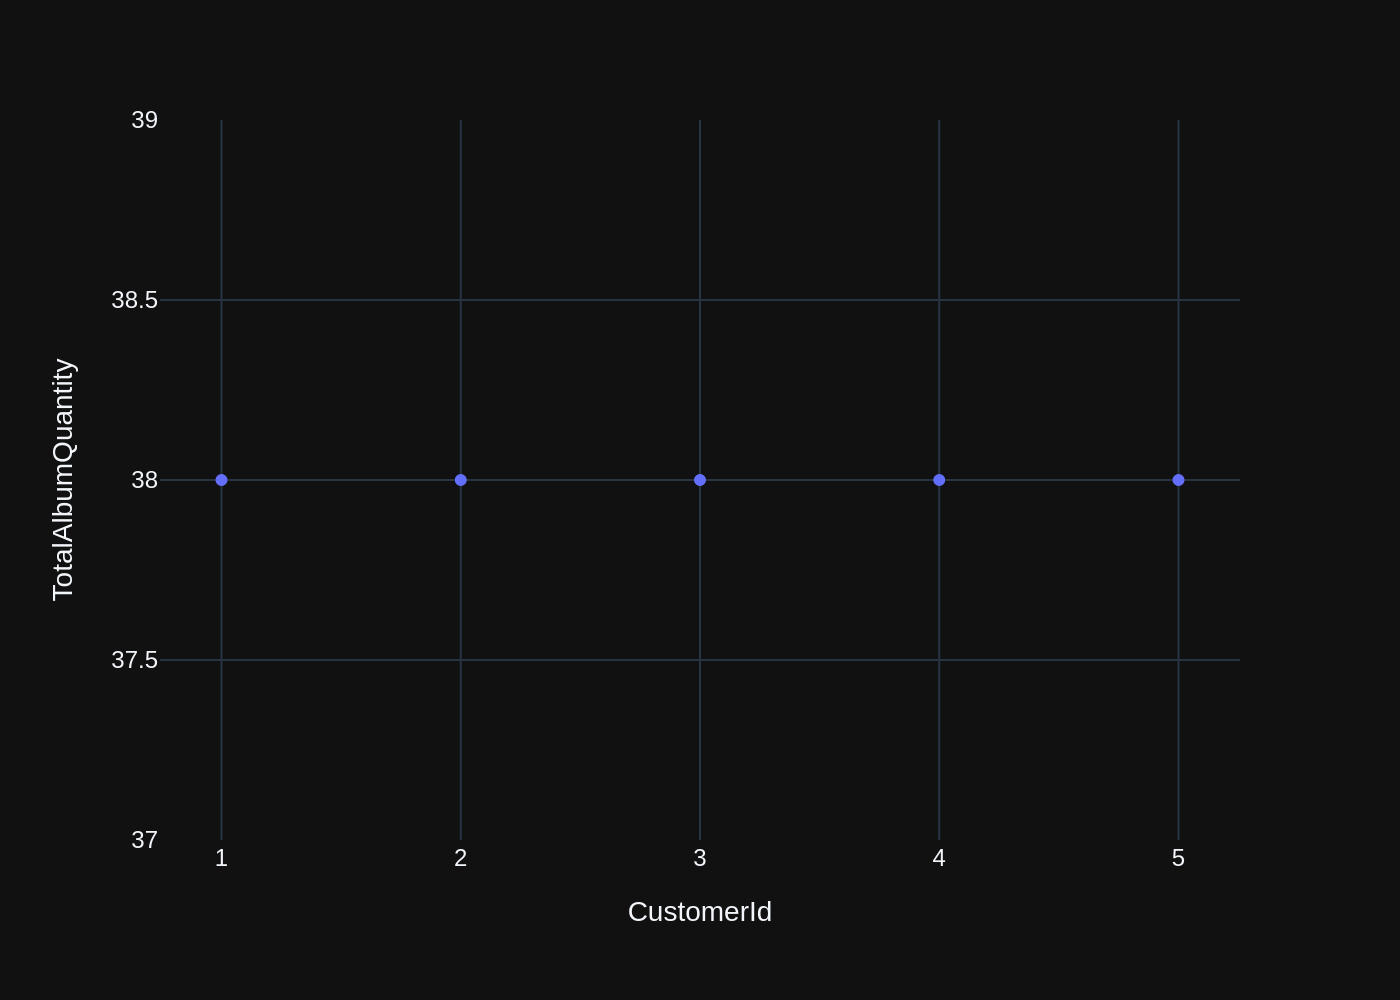





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt:   
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
     with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt:   
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
     with the following exception: 
an un

SELECT pl.Name AS PlaylistName, SUM(t.Milliseconds) AS TotalDuration
FROM playlists pl
JOIN playlist_track pt ON pl.PlaylistId = pt.PlaylistId
JOIN tracks t ON pt.TrackId = t.TrackId
GROUP BY pl.PlaylistId
HAVING COUNT(pt.TrackId) >= 10;


[( <DataFrame> )]
queried dataframe



,PlaylistName,TotalDuration
0,Music,877683083
1,TV Shows,501094957
2,90’s Music,398705153
3,Music,877683083
4,TV Shows,501094957
5,Brazilian Music,9486559
6,Classical,21770592
7,Classical 101 - Deep Cuts,6755730
8,Classical 101 - Next Steps,7575051
9,Classical 101 - The Basics,7439811



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['TotalDuration'].iloc[0],
        title={"text": f"Total Duration of Tracks in Playlist<br><span style='font-size:0.8em;color:gray'>Playlist Name: {df['PlaylistName'].iloc[0]}</span>"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['PlaylistName'], y=df['TotalDuration'])])

fig.update_layout(title='Total Duration of Tracks in Each Playlist', xaxis_title='Playlist Name', yaxis_title='Total Duration (Milliseconds)')

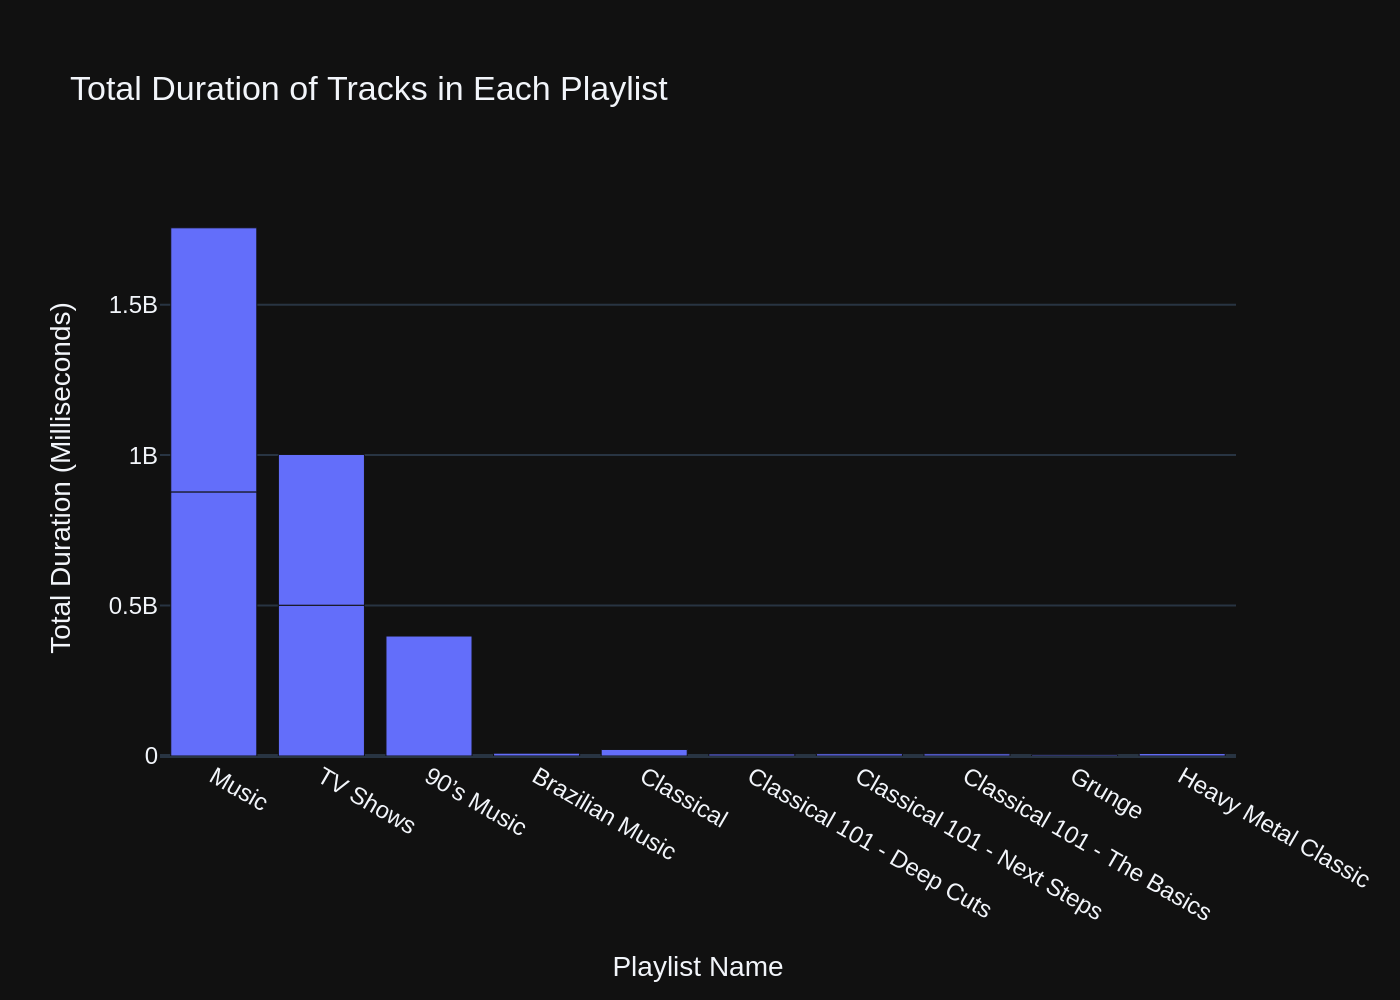





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( EXTRACTED SQL )]
with tracks appearing in multiple genres, we can join the `artists`, `albums`, `tracks`, and `genres` tables. We will group by artist to count distinct genre IDs for each album, then filter out those having more than one unique genre ID. Here's how you could write the SQL query:

```sql
SELECT a.ArtistId, a.Name AS ArtistName, COUNT(DISTINCT t.GenreId) AS NumberOfGenresWithTracks
FROM artists a
JOIN albums al ON a.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY a.ArtistId
HAVING COUNT(DISTINCT t.GenreId) > 1;


[( <SQL> )]
generated SQL statement



with tracks appearing in multiple genres, we can join the `artists`, `albums`, `tracks`, and `genres` tables. We will group by artist to count distinct genre IDs for each album, then filter out those having more than one unique genre ID. Here's how you could write the SQL query:

```sql
SELECT a.ArtistId, a.Name AS ArtistName, COUNT(DISTINCT t.GenreId) AS NumberOfGenresWithTracks
FROM artists a
JOIN albums al ON a.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY a.ArtistId
HAVING COUNT(DISTINCT t.GenreId) > 1;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: Identify artists who have albums with tracks appearing in multiple genres:
                    results in the following error: [ERROR-DB] Failed to execute SQL: with tracks appearing in multiple genres, we can join the `artists`, `albums`, `tracks`, and `genres` tables. We will group by artist to count distinct genre IDs for each album, then filter out those having more than one unique genre ID. Here's how you could write the SQL query:

```sql
SELECT a.ArtistId, a.Name AS ArtistName, COUNT(DISTINCT t.GenreId) AS NumberOfGenresWithTracks
FROM artists a
JOIN albums al ON a.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY a.ArtistId
HAVING COUNT(DISTINCT t.GenreId) > 1 LIMIT 20
 Execution failed on sql 'with tracks appearing in multiple genres, we can join t

In [15]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

### Check completion time

In [16]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'deepseek-coder-v2' 
 took 559 sec
 run on 'ducklover1' 
 at 20241123-000045


In [17]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-deepseek-coder-v2-559s-ducklover1-20241123-000045.csv'

### Save training data

In [18]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,097859bf-2c7a-5182-840e-a1760c69848c-sql,List all invoices with a total exceeding $10,"SELECT InvoiceId, CustomerId, InvoiceDate, Tot...",sql
1,0a39f28e-4263-5d39-99c9-d3384f17923b-sql,\n Find the top 5 customers who b...,"SELECT c.CustomerId, c.FirstName, c.LastName, ...",sql
2,1274052b-0b10-54f8-a044-94bd0c6b6955-sql,How many customers are there,SELECT COUNT(*) AS NumberOfCustomers FROM cust...,sql
3,1be5543a-02ef-54ce-8d87-b8a9e39bfb02-sql,which table stores customer's orders,SELECT name FROM sqlite_master WHERE type='tab...,sql
4,1dd155f4-d962-5a04-8998-8a42ad3e6c95-sql,List all albums and their corresponding artist...,"SELECT a.Title AS AlbumTitle, ar.Name AS Artis...",sql
5,21bb6828-db93-5dfa-864a-82156d1f35bb-sql,Get the average invoice total for each customer:,"SELECT c.CustomerId, c.FirstName, c.LastName, ...",sql
6,276c9f6c-1d69-5666-adda-78a4f4eaeeeb-sql,\n Can you find the top 10 most popula...,"SELECT a.ArtistId, a.Name AS ArtistName, COUNT...",sql
7,328a8876-d07f-5be1-b675-b85f06151fae-sql,Get all playlists containing at least 10 track...,"SELECT pl.Name AS PlaylistName, SUM(t.Millisec...",sql
8,3a06e1a2-9793-56a5-a3c6-f88d4eda0544-sql,\n Generating SQL for this ...,"SELECT FirstName, LastName, Email\nFROM custom...",sql
9,4a1b8b9e-2ed9-57b3-8436-05d8d5ba0fa7-sql,List all genres and the number of tracks in ea...,"SELECT g.Name AS GenreName, COUNT(t.TrackId) A...",sql


In [19]:
df_training_data.to_csv(file_csv, index=False)